# CSM148 Project3

In [308]:
#Here are a set of libraries we imported to complete this assignment. 
#Feel free to use these or equivalent libraries for your implementation
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # this is used for the plot the graph 
from matplotlib.colors import ListedColormap
import os
import seaborn as sns # used for plot interactive graph.
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import metrics
from sklearn.svm import SVC  
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import sklearn.metrics.cluster as smc
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from matplotlib import pyplot
import itertools


In [309]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")

In [310]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [311]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [312]:
df['stroke'].value_counts()
# the stroke data are much less than non stroke, so that we need to make then even.
df.nunique()

id                   5110
gender                  3
age                   104
hypertension            2
heart_disease           2
ever_married            2
work_type               5
Residence_type          2
avg_glucose_level    3979
bmi                   418
smoking_status          4
stroke                  2
dtype: int64

In [313]:
features_dropped = ['id']

In [314]:
dropped_df = df.drop(features_dropped, axis=1)
dropped_df.nunique()

gender                  3
age                   104
hypertension            2
heart_disease           2
ever_married            2
work_type               5
Residence_type          2
avg_glucose_level    3979
bmi                   418
smoking_status          4
stroke                  2
dtype: int64

In [315]:
dropped_df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [316]:
# Since we don't hava a larger number of data in this project, we don't want to simply deletes the rows or the possibly correlated feature
# I used the median to replace the missing value.
median = dropped_df['bmi'].median()
dropped_df['bmi'].fillna(median, inplace=True) # option 3: replace na values with median values
dropped_df.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

Now, we have clear all the n/a values and start to deal with the categorical values. We can plot a heatmap to see the correlation.

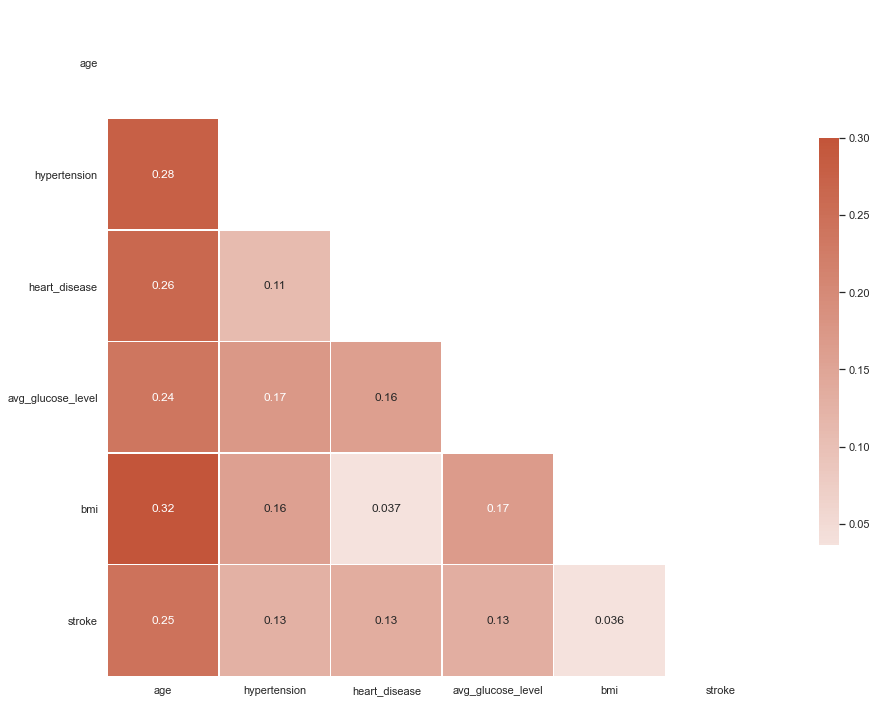

In [317]:
import matplotlib.transforms
import seaborn as sns
sns.set(style="white")
corr = dropped_df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f,ax = plt.subplots(figsize=(15,15))
cmap = sns.diverging_palette(230,20,as_cmap=True)
sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.yticks(rotation = 0)
plt.show()

In [318]:
# The relationship between bmi and stroke is relatively low (0.036), hence, we may can drop the feature 'BMI'.
dropped_df = dropped_df.drop('bmi', axis=1)
dropped_df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,never smoked,1
...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,never smoked,0
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,never smoked,0
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,never smoked,0
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,formerly smoked,0


In [348]:
# Seperate features and response
df_y = dropped_df['stroke'].copy()
df_x = dropped_df.drop('stroke', axis=1)
df_x.shape, df_y.shape

((5110, 9), (5110,))

In [349]:
type(train_X)

numpy.ndarray

In [350]:
type(train_y)

pandas.core.series.Series

In [329]:
categorical_features = ['gender', 'hypertension', 'heart_disease',
    'ever_married', 'work_type', 'Residence_type','smoking_status']
numerical_features = ['age','avg_glucose_level']

num_pipeline = Pipeline([('std_scaler', StandardScaler()), ])

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, numerical_features),
    ("cat", OneHotEncoder(), categorical_features)])

In [335]:
train_prepared = full_pipeline.fit_transform(df_x)
train_prepared.shape

(5110, 22)

In [336]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(train_prepared, df_y, test_size=0.2, random_state=42)
train_X.shape, train_y.shape, test_X.shape, test_y.shape



((4088, 22), (4088,), (1022, 22), (1022,))

Logistic Regression

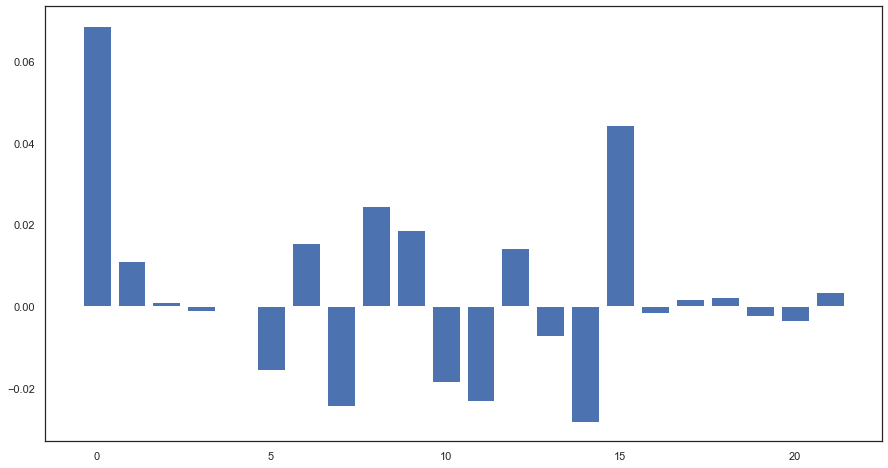

In [337]:
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

# Linear Regression Feature Importance
model = LinearRegression()
model.fit(train_X, train_y)
importance = model.coef_
plt.figure(figsize=(15, 8))
plt.bar([x for x in range(len(importance))], importance)
plt.show()

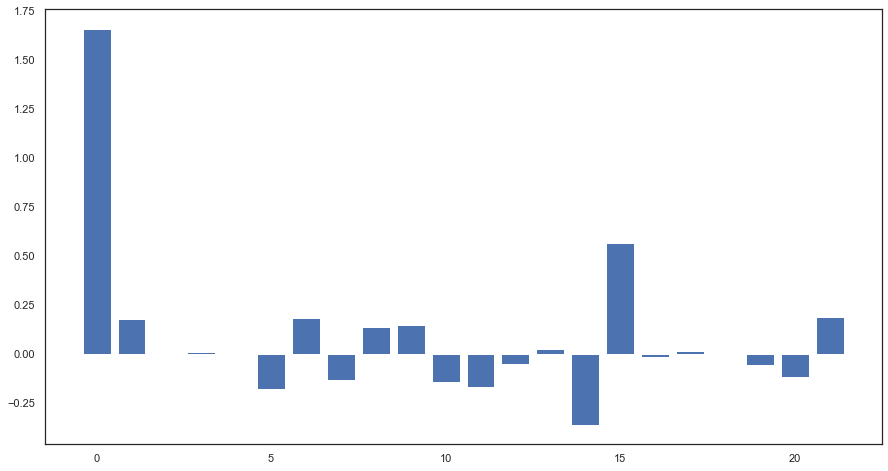

In [338]:
# Logistic Regression Feature Importance
model = LogisticRegression()
model.fit(train_X, train_y)
importance = model.coef_[0]
plt.figure(figsize=(15, 8))
plt.bar([x for x in range(len(importance))], importance)
plt.show()

PCA

In [307]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)


AttributeError: 'numpy.ndarray' object has no attribute 'toarray'